In [4]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as ker
import tensorflow.keras.layers as layer
import numpy as np
import matplotlib.pyplot as plt


train = pd.read_csv('E:\\Alex\\Python_Files\\KBTU_Test\\train.csv')
sample = pd.read_csv('E:\\Alex\\Python_Files\\KBTU_Test\\sample_submission.csv')
#train.head(5)
#test.describe()

In [5]:
gen = {'Male': 0, 'Female': 1}
train['gender'] = train['gender'].map(gen)



edu = {'High School': 0, 'Master’s': 1, 'Bachelor’s': 2}
train['parental_education'] = train['parental_education'].map(edu)


school = {'Public': 0, 'Private': 1}
train['school_type'] = train['school_type'].map(school)
#train.head()

In [6]:
student_id = train['student_id']
train = train.drop(columns='student_id')


In [7]:
train

,gender,age,study_hours,attendance_rate,previous_scores,parental_education,school_type,extracurricular,final_math_score
0,0,17,9.1,68.7,70.0,2,1,3,86.2
1,1,17,10.5,66.6,84.8,2,0,3,90.6
2,0,17,17.4,58.8,73.8,0,1,3,94.1
3,0,17,8.1,80.4,45.0,0,0,1,82.9
4,0,18,17.7,73.8,51.1,1,0,2,98.6
...,...,...,...,...,...,...,...,...,...
3995,1,18,11.3,71.2,43.6,0,0,4,78.8
3996,1,15,5.0,95.8,53.6,0,0,3,80.5
3997,1,16,19.6,74.9,55.6,2,0,2,93.0
3998,1,15,3.9,69.9,63.2,1,1,3,70.9


In [8]:
# Преобразуем train_data в тензор
train_data = tf.convert_to_tensor(train.values, dtype=tf.float32)

mean, variance = tf.nn.moments(train_data, axes=[0])
std = tf.sqrt(variance)

# Нормализуем данные
normalized_data = (train_data - mean) / std

# Преобразуем обратно в DataFrame
normalized_array = normalized_data.numpy()
train = pd.DataFrame(normalized_array, columns=train.columns)
train

,gender,age,study_hours,attendance_rate,previous_scores,parental_education,school_type,extracurricular,final_math_score
0,-1.003501,0.434803,-0.334204,-0.434686,-0.029563,1.260821,1.020205,0.689996,-0.107247
1,0.996501,0.434803,-0.062726,-0.579004,0.830140,1.260821,-0.980197,0.689996,0.253565
2,-1.003501,0.434803,1.275274,-1.115042,0.191172,-1.176136,1.020205,0.689996,0.540574
3,-1.003501,0.434803,-0.528117,0.369370,-1.481764,-1.176136,-0.980197,-0.721039,-0.377855
4,-1.003501,1.330380,1.333448,-0.084200,-1.127427,0.042342,-0.980197,-0.015521,0.909585
...,...,...,...,...,...,...,...,...,...
3995,0.996501,1.330380,0.092404,-0.262880,-1.563088,-1.176136,-0.980197,1.395514,-0.714065
3996,0.996501,-1.356351,-1.129248,1.427701,-0.982207,-1.176136,-0.980197,0.689996,-0.574661
3997,0.996501,-0.460774,1.701882,-0.008605,-0.866031,1.260821,-0.980197,-0.015521,0.450371
3998,0.996501,-1.356351,-1.342552,-0.352219,-0.424562,0.042342,1.020205,0.689996,-1.361886


In [9]:
y = train['final_math_score']
x = train.drop(columns='final_math_score')
in_layer = len(train.columns) -1

In [10]:
# Сохраняем среднее и стандартное отклонение только по целевой переменной
target_mean = mean[-1].numpy()
target_std = std[-1].numpy()


In [11]:

batch = 32
epochs=100
data = tf.data.Dataset.from_tensor_slices((x.values, y.values)).shuffle(len(x))
train_size = int(len(x) * 0.8)
train_data = data.take(train_size).batch(batch)
val_data = data.skip(train_size).batch(batch)

model = tf.keras.Sequential([
  
    layer.Dense(512, activation='swish', input_shape=(in_layer,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layer.BatchNormalization(),
    layer.Dropout(0.3),  

    layer.Dense(256, activation='swish',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layer.BatchNormalization(),
    layer.Dropout(0.3),
    

    layer.Dense(128, activation='swish',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layer.BatchNormalization(),
    layer.Dropout(0.3),
    

    layer.Dense(64, activation='swish'),
    layer.Dense(32, activation='swish'),
    layer.Dense(1, activation='linear'),
    layer.Lambda(lambda x: tf.minimum(x, 100))
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  
    loss=tf.keras.losses.Huber(),
    metrics=['mae', 'mse']
)

e:\Alex\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_data,
    batch_size=batch,
    epochs=epochs,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.2801 - mae: 0.6642 - mse: 0.7268 - val_loss: 4.3364 - val_mae: 0.7372 - val_mse: 0.8244 - learning_rate: 5.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8075 - mae: 0.4341 - mse: 0.3215 - val_loss: 3.0378 - val_mae: 0.6631 - val_mse: 0.6726 - learning_rate: 5.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5885 - mae: 0.3613 - mse: 0.2174 - val_loss: 2.0357 - val_mae: 0.5862 - val_mse: 0.5384 - learning_rate: 5.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7231 - mae: 0.3612 - mse: 0.2357 - val_loss: 1.3173 - val_mae: 0.4886 - val_mse: 0.3829 - learning_rate: 5.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1190 - mae: 0.3477 - mse: 0.2082 - val_loss: 0.8530 - val_mae: 0.4291 - val_mse: 0.2924 - learning_rate: 5.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7345 - mae: 0.3389 - mse: 0.1991 - val_los

Text(0.5, 1.0, 'Training and Validation Loss')

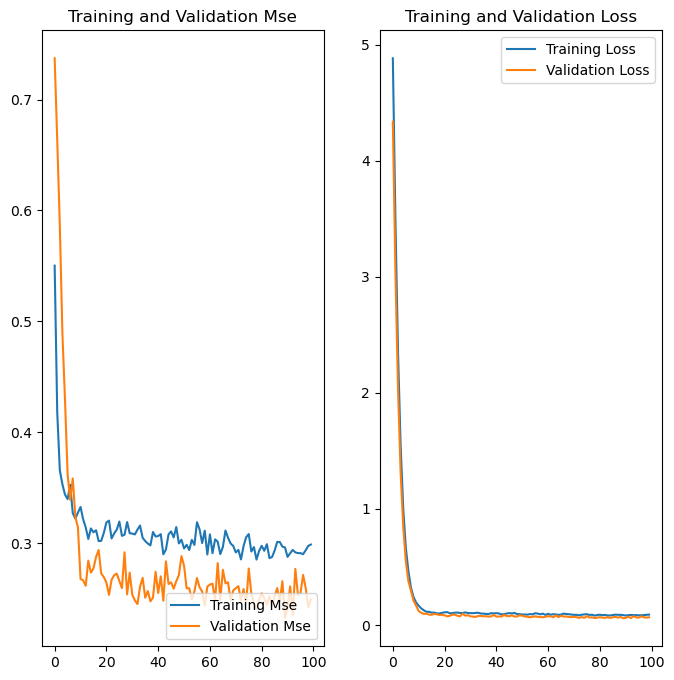

In [13]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
history.history['val_mae']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training Mse')
plt.plot(epochs_range, val_mae, label='Validation Mse')
plt.legend(loc='lower right')
plt.title('Training and Validation Mse')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [14]:
x_val = x.values[train_size:] 
y_val = y.values[train_size:]



data_pred = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch)


predictions = model.predict(data_pred)


df_results = pd.DataFrame({
    'final_math_score_val': y_val,
    'predicted_score': predictions.flatten()
})

df_results['predicted_score_denorm'] = df_results['predicted_score'] * target_std + target_mean
df_results['final_math_score_val_denorm'] = df_results['final_math_score_val'] * target_std + target_mean


df_results.head(10)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


,final_math_score_val,predicted_score,predicted_score_denorm,final_math_score_val_denorm
0,-0.763267,-0.806806,77.669052,78.199997
1,0.023958,0.100502,88.733437,87.800003
2,1.024389,1.038354,100.170296,100.000000
3,0.474972,0.953011,99.129562,93.300003
4,-0.533660,-0.279932,84.094139,81.000000
5,-0.369655,-0.045081,86.958092,83.000000
6,-0.427056,-0.295413,83.905357,82.300003
7,0.335567,-0.359902,83.118935,91.599998
8,-0.861670,-0.675585,79.269264,77.000000
9,0.556975,0.584144,94.631332,94.300003


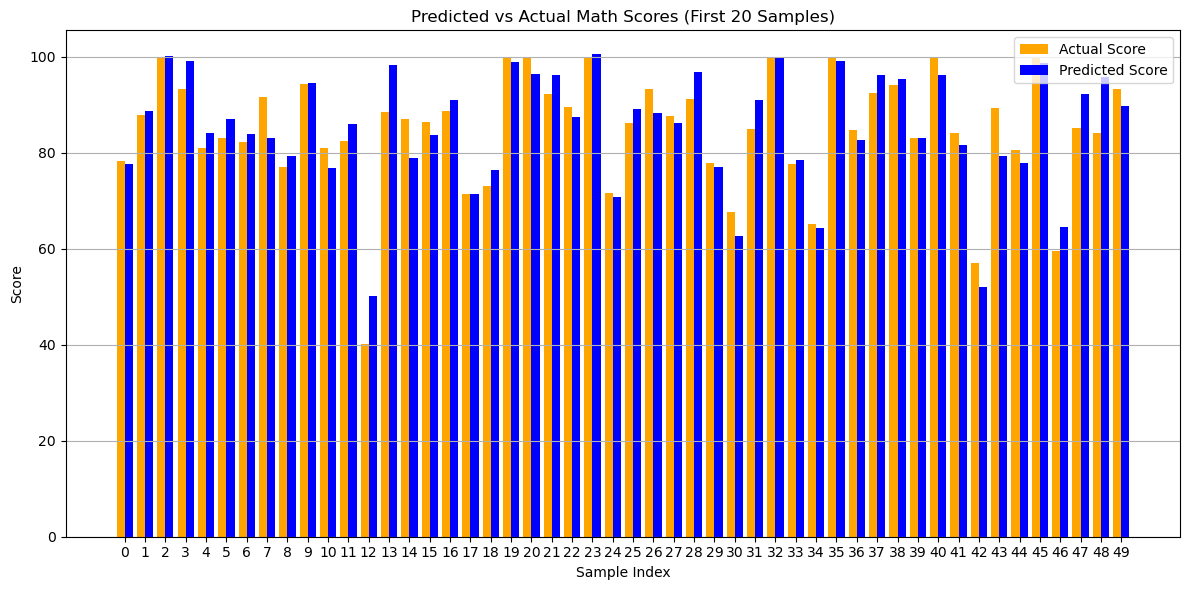

In [15]:
# Выбираем первые 20 значений
df_sample = df_results.head(50)

# Количество элементов
n = len(df_sample)
indices = np.arange(n)
width = 0.4

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(indices - width/2, df_sample['final_math_score_val_denorm'], width=width, label='Actual Score', color='orange')
plt.bar(indices + width/2, df_sample['predicted_score_denorm'], width=width, label='Predicted Score', color='blue')

# Подписи и оформление
plt.title('Predicted vs Actual Math Scores (First 20 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Score')
plt.xticks(indices)  # чтобы были видны индексы по оси X
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

# Показ графика
plt.show()


In [16]:
#сsv с ответами
test = pd.read_csv('E:\\Alex\\Python_Files\\KBTU_Test\\test.csv')
test['gender'] = test['gender'].map(gen)
test['parental_education'] = test['parental_education'].map(edu)
test['school_type'] = test['school_type'].map(school)
test_students = test['student_id']
test = test.drop(columns='student_id')



#нормализ
test_n = (test - mean[:-1].numpy()) / std[:-1].numpy()

pred = model.predict(test_n)

#денорм
pred_dn = pred * target_std + target_mean

test['predicted_math_score'] = pred_dn
test['student_id'] = test_students
test[['student_id', 'predicted_math_score']].to_csv('E:\\Alex\\Python_Files\\KBTU_Test\\answer.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [17]:
ans = pd.read_csv('E:\\Alex\\Python_Files\\KBTU_Test\\answer.csv')
ans.head(10)
#----------------------

,student_id,predicted_math_score
0,5001,91.930374
1,5002,73.161064
2,5003,84.722595
3,5004,73.504364
4,5005,99.302980
5,5006,89.031700
6,5007,88.164430
7,5008,97.343950
8,5009,74.249100
9,5010,92.097240
